<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-Variables" data-toc-modified-id="Project-Variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project Variables</a></span></li><li><span><a href="#Dataset-and-Pipelines" data-toc-modified-id="Dataset-and-Pipelines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset and Pipelines</a></span></li><li><span><a href="#Building-the-Deep-NN" data-toc-modified-id="Building-the-Deep-NN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building the Deep NN</a></span><ul class="toc-item"><li><span><a href="#Network-Variables" data-toc-modified-id="Network-Variables-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Network Variables</a></span></li><li><span><a href="#Construction-Phase" data-toc-modified-id="Construction-Phase-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Construction Phase</a></span></li><li><span><a href="#Execution-Phase" data-toc-modified-id="Execution-Phase-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Execution Phase</a></span></li></ul></li></ul></div>

The goal of this notebook is building a sentiment classification model using plain TensorFlow. For making this task easier, we will use data prep steps (like pipelines and text functions) for preparing the data for feeding a neural network.

In [108]:
# Standard libraries
import os
import pandas as pd
from joblib import load
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Utilities
from utils.custom_transformers import import_data
from utils.dnn_utils import fetch_batch
from utils.viz_utils import format_spines

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Project Variables

In [2]:
# Variables for path definition
DATA_PATH = '../../data'
PIPE_PATH = '../../pipelines'

# Variables reading files
DATASET_FILENAME = 'olist_order_reviews_dataset.csv'
DATASET_COLS = ['review_comment_message', 'review_score']
FEATURES_COL = 'review_comment_message'
TARGET_COL = 'review_score'

# Variables for reading pipelines
TEXT_PIPE = 'text_prep_pipeline.pkl'

# Dataset and Pipelines

By now, let's read the raw data and apply the text prep pipeline already built on python training script on `dev/training` project folder. The goal is to give the raw text as input and transform this data into features using the vectorizer implemented on the pipeline (`TfIdfVectorizer`).

In [86]:
# Reading the data and dropping duplicates
df = pd.read_csv(os.path.join(DATA_PATH, DATASET_FILENAME), usecols=DATASET_COLS)
df.dropna(inplace=True)

# Splitting the data into train and test
X = df[FEATURES_COL].values
y = df[TARGET_COL].values

# Reading the pipeline
text_prep_pipe = load(os.path.join(PIPE_PATH, TEXT_PIPE))

# Applying it to training data
X_prep = text_prep_pipe.fit_transform(X)

# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=.20, random_state=42)

# Converting to array
X_train = X_train.toarray()
X_test = X_test.toarray()

# Results
for data, name in zip([X_train, X_test], ['X_train', 'X_test']):
    print('-' * 50)
    print(f'Shape of {name} data: {data.shape}')
print(f'\nSamples of y_train: {y_train[:5]}')
print(f'Samples of y_test: {y_test[:5]}')

--------------------------------------------------
Shape of X_train data: (33402, 650)
--------------------------------------------------
Shape of X_test data: (8351, 650)

Samples of y_train: [1 4 4 5 5]
Samples of y_test: [1 1 3 3 1]


# Building the Deep NN

After rading and preparing the data for feeding it into a neural network, let's retrieve some useful parameters for the network.

## Network Variables

In [87]:
# Retrieving data info
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

# Transforming the classes in one hot vectors
y_train_oh = pd.get_dummies(y_train).values.astype('int')
y_test_oh = pd.get_dummies(y_test).values.astype('int')

# Neural network structure
n_hidden1 = 300
n_hidden2 = 100

# Overview
print('-' * 40)
print(f'Neural network inputs: {n_inputs}')
print(f'Number of classes: {n_outputs} - Sample: {y_train_oh[0]}')
print(f'\nStructure:')
print(f'{n_inputs} -> {n_hidden1} -> {n_hidden2} -> {n_outputs}')
print('-' * 40)

----------------------------------------
Neural network inputs: 650
Number of classes: 5 - Sample: [1 0 0 0 0]

Structure:
650 -> 300 -> 100 -> 5
----------------------------------------


## Construction Phase

Now, let's build the computation graph for our Neural Network using TensorFlow 

In [101]:
# ----------------------------
# ---- CONSTRUCTION PHASE ----
# ----------------------------

# Creating placeholders for receiving mini-batches
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
    y = tf.placeholder(tf.int32, shape=(None, n_outputs), name='y')
    
# Building layers
with tf.name_scope('layers'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')
    
# Defining cost function
with tf.name_scope('loss'):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
# Defining optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    training_op = optimizer.minimize(loss)
    
# Node for performance evaluation
with tf.name_scope('accuracy'):
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
# Node for initializing all global variables
init = tf.global_variables_initializer()

## Execution Phase

In [107]:
# Defining training variables
m_train = X_train.shape[0]
n_epochs = 100
batch_size = 128
n_batches = m_train // batch_size
costs = []

# Initializing a TensorFlow session
with tf.Session() as sess:
    
    # Initializing global variables
    init.run()
    
    # Iterating over training epochs
    for epoch in range(n_epochs):
        # Iterating over mini-batches
        for batch in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train, y_train_oh, epoch, batch, batch_size)
            
            # Running training using mini-batches
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        # Evaluating metrics each 5 epochs
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test_oh})
            print(f'Epoch: {epoch:>5} - Acc Train: {round(float(acc_train), 4):>5} - Acc Test: {round(float(acc_test), 4):>5}')
                
        # Evaluating costs
        cost = loss.eval(feed_dict={X: X_batch, y: y_batch})
        costs.append(cost)

Epoch:     0 - Acc Train: 0.7578 - Acc Test: 0.6809
Epoch:     5 - Acc Train: 0.875 - Acc Test: 0.6609
Epoch:    10 - Acc Train: 0.8906 - Acc Test: 0.644
Epoch:    15 - Acc Train: 0.9219 - Acc Test: 0.6436
Epoch:    20 - Acc Train: 0.9531 - Acc Test: 0.6433
Epoch:    25 - Acc Train: 0.9453 - Acc Test: 0.6344
Epoch:    30 - Acc Train: 0.9297 - Acc Test: 0.6318
Epoch:    35 - Acc Train: 0.9062 - Acc Test: 0.6344
Epoch:    40 - Acc Train: 0.9375 - Acc Test: 0.6329
Epoch:    45 - Acc Train: 0.9062 - Acc Test: 0.6293
Epoch:    50 - Acc Train: 0.875 - Acc Test: 0.6365
Epoch:    55 - Acc Train: 0.9062 - Acc Test: 0.6291
Epoch:    60 - Acc Train: 0.8906 - Acc Test: 0.6367
Epoch:    65 - Acc Train: 0.9531 - Acc Test: 0.6378
Epoch:    70 - Acc Train: 0.9453 - Acc Test: 0.6238
Epoch:    75 - Acc Train: 0.9219 - Acc Test: 0.6318
Epoch:    80 - Acc Train: 0.875 - Acc Test: 0.6277
Epoch:    85 - Acc Train: 0.9062 - Acc Test: 0.6335
Epoch:    90 - Acc Train: 0.9453 - Acc Test: 0.6323
Epoch:    95 - A

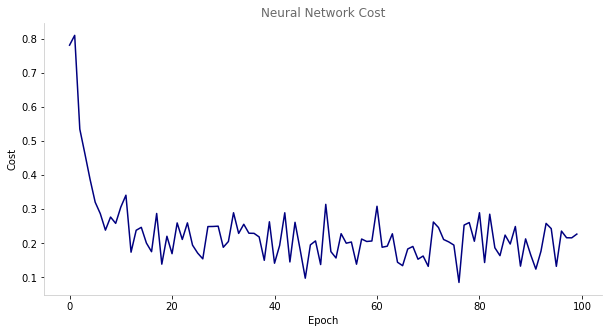

In [109]:
# Plotando custo
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.squeeze(costs), color='navy')
format_spines(ax, right_border=False)
ax.set_title('Neural Network Cost', color='dimgrey')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
plt.show()